In [1]:
# %%writefile cluster2clf.py 
import numpy as np
import pandas as pd
from os.path import join
from scripts.utils import read_pkl_file
from sklearn.metrics import precision_recall_fscore_support


def get_clustering_results(res_dir, hdoi_threshold=0.95, return_full_table=False):
    cluster_table = pd.read_csv(join(res_dir, "cluster_table.csv"))
    
    if not return_full_table:
        cluster_table = cluster_table.copy()[["cluster", "% pos"]]
    
    class_2_text_indices_map = read_pkl_file(join(res_dir, "class_2_text_indices_map.pkl"))
    hdoi_clusters = cluster_table[cluster_table["% pos"] >= hdoi_threshold]
    
    return hdoi_clusters, class_2_text_indices_map


def fill_data_with_cluster_labels(data, class_2_text_indices_map, return_full_table=False):
    data = data.copy()
    
    if not return_full_table:
        data = data[["docID", "label"]]
    
    data.insert(0, "cluster", "")
    
    for c, ixes in class_2_text_indices_map.items():
        data.loc[ixes.tolist(), "cluster"] = c
    
    return data


def fill_gold_label_table(hdoi_clusters, class_2_text_indices_map, 
                          clustered_data, gold_label_table=None):
    
    if gold_label_table is None:
        gold_label_table = clustered_data[["docID", "label"]].drop_duplicates()
        gold_label_table.reset_index(drop=True, inplace=True)
    
    num_targets = "# parts in hdoi clusters"
    num_clusters = "# hdoi clusters associated"
    gold_label_table[num_targets] = 0
    gold_label_table[num_clusters] = 0
    
    for c in hdoi_clusters.cluster:
        docIDs = clustered_data.docID[class_2_text_indices_map[c]]
        unique = docIDs.unique()
        id_to_count = docIDs.value_counts().to_dict()
        
        for docID in id_to_count:
            ix = gold_label_table[gold_label_table.docID == docID].index[0]
            gold_label_table.at[ix, num_targets] += id_to_count[docID]
            gold_label_table.at[ix, num_clusters] += 1
    
    return gold_label_table


def predict(num, threshold):
    if num >= threshold:
        return True
    return False


def get_precision_recall_f1(filled_gold_label_table, threshold=1):
    p = lambda num: predict(num, threshold)
    preds = filled_gold_label_table["# parts in hdoi clusters"].map(p)
    labels = filled_gold_label_table["label"] == "pos"
    scores = precision_recall_fscore_support(labels, preds, 
                                             average="binary", zero_division=0)   
    return scores[:3]


def evaluate_clustering_results(data, res_dir, hdoi_threshold=0.95, num_threshold=1,
                                gold_label_table=None, return_cluster_size=False):
    hdoi_clusters, class_2_text_indices_map = get_clustering_results(res_dir, hdoi_threshold)
    clustered_data = fill_data_with_cluster_labels(data, class_2_text_indices_map)
    filled_gold_label_table = fill_gold_label_table(hdoi_clusters, class_2_text_indices_map, 
                                                    clustered_data, gold_label_table)
    
    scores = get_precision_recall_f1(filled_gold_label_table, num_threshold)
    if return_cluster_size:
        return [len(hdoi_clusters), len(class_2_text_indices_map)], scores
    return scores

# For a single clustering experiment

In [3]:
from os.path import join, isdir
from os import listdir


def get_sub_dirs(dire, name_only=False):
    prefix = dire if not name_only else ""
    out = [join(prefix, sub) for sub in listdir(dire) 
           if isdir(join(dire, sub))]
    return out


res_dirs = []
ds = "train"
clustering_dir = f"experiments/sentence-level/results_{ds}/clustering/"
data = pd.read_csv(join(clustering_dir, "data.csv"))
gold_label_table = pd.read_csv(f"experiments/doc-level/{ds}.csv")


for method in ["kmeans", "hdbscan"]:
    directory = join(clustering_dir, method)
    res_dirs.extend(get_sub_dirs(directory))

In [5]:
res_dir

'experiments/sentence-level/results_train/clustering/kmeans/dim=full numOfClusters=60 run=2'

In [4]:
from tqdm import tqdm

res_dir = res_dirs[44]
results = []
cols = ["hdoi threshold", "num_threshold", "precision", "recall", "f1", 
        "# hdoi clusters", "cluster size"]

for threshold in tqdm(np.linspace(0.7, 0.95, 6)):
    for num_threshold in [1,2,3]:
        sizes, scores = evaluate_clustering_results(data, res_dir, threshold, 
                                                 num_threshold, gold_label_table, True)
        results.append([threshold, num_threshold] + list(scores) + list(sizes))

results_df = pd.DataFrame(results, columns=cols)
results_df

100%|███████████████████████████████████████████| 6/6 [00:04<00:00,  1.22it/s]


,hdoi threshold,num_threshold,precision,recall,f1,# hdoi clusters,cluster size
0,0.70,1,0.729560,0.836538,0.779395,4,60
1,0.70,2,0.847222,0.586538,0.693182,4,60
2,0.70,3,0.893004,0.521635,0.658574,4,60
3,0.75,1,0.729560,0.836538,0.779395,4,60
4,0.75,2,0.847222,0.586538,0.693182,4,60
5,0.75,3,0.893004,0.521635,0.658574,4,60
6,0.80,1,0.729560,0.836538,0.779395,4,60
7,0.80,2,0.847222,0.586538,0.693182,4,60
8,0.80,3,0.893004,0.521635,0.658574,4,60
9,0.85,1,0.841975,0.819712,0.830694,3,60


### Plotting all clustering experiments (without aggregation)

In [6]:
results_all = []
num_threshold = 1
cols = ["res dir", "hdoi threshold", "num_threshold", "precision", "recall", "f1", 
        "# hdoi clusters", "cluster size"]

for res_dir in tqdm(res_dirs):
    for threshold in np.linspace(0.7, 0.95, 6):
        sizes, scores = evaluate_clustering_results(data, res_dir, threshold, 
                                                 num_threshold, gold_label_table, True)

        results_all.append([res_dir, threshold, num_threshold] + list(scores) + sizes)

results_all_df = pd.DataFrame(results_all, columns=cols)
results_all_df

100%|███████████████████████████████████████| 135/135 [03:04<00:00,  1.37s/it]


,res dir,hdoi threshold,num_threshold,precision,recall,f1,# hdoi clusters,cluster size
0,experiments/sentence-level/results_train/clust...,0.70,1,0.597015,0.769231,0.672269,2,30
1,experiments/sentence-level/results_train/clust...,0.75,1,0.597015,0.769231,0.672269,2,30
2,experiments/sentence-level/results_train/clust...,0.80,1,0.906667,0.653846,0.759777,1,30
3,experiments/sentence-level/results_train/clust...,0.85,1,0.906667,0.653846,0.759777,1,30
4,experiments/sentence-level/results_train/clust...,0.90,1,0.906667,0.653846,0.759777,1,30
...,...,...,...,...,...,...,...,...
805,experiments/sentence-level/results_train/clust...,0.75,1,0.581952,0.759615,0.659020,1,3
806,experiments/sentence-level/results_train/clust...,0.80,1,0.581952,0.759615,0.659020,1,3
807,experiments/sentence-level/results_train/clust...,0.85,1,0.581952,0.759615,0.659020,1,3
808,experiments/sentence-level/results_train/clust...,0.90,1,0.000000,0.000000,0.000000,0,3


<Axes: title={'center': 'f1'}, xlabel='[hdoi threshold]'>

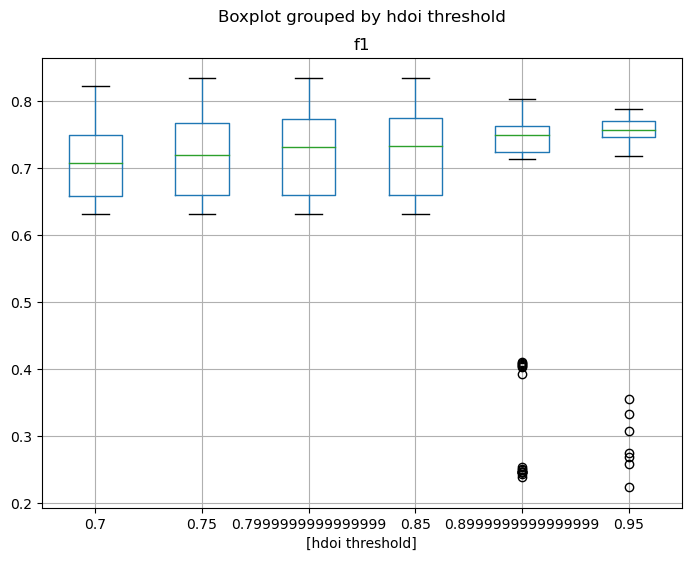

In [8]:
results_all_df[["f1", "hdoi threshold"]].boxplot(by=["hdoi threshold"], figsize=(8,6))

In [9]:
results_all_df = results_all_df[results_all_df["# hdoi clusters"] > 0]
kmeans = results_all_df[results_all_df["res dir"].str.contains("kmeans")]
hdbscan = results_all_df[results_all_df["res dir"].str.contains("hdbscan")]

hdbscan[hdbscan.columns[2:-1]].describe()

,num_threshold,precision,recall,f1,# hdoi clusters
count,311.0,311.000000,311.000000,311.000000,311.000000
mean,1.0,0.659307,0.723055,0.662822,19.135048
std,0.0,0.117266,0.163166,0.114842,29.652086
min,1.0,0.540678,0.127404,0.224101,1.000000
25%,1.0,0.577068,0.737981,0.649104,1.000000
50%,1.0,0.596026,0.747596,0.663874,2.000000
75%,1.0,0.740725,0.766827,0.724193,27.000000
max,1.0,0.945652,0.865385,0.803129,104.000000


In [10]:
kmeans[kmeans.columns[2:-1]].describe()

,num_threshold,precision,recall,f1,# hdoi clusters
count,267.0,267.000000,267.000000,267.000000,267.000000
mean,1.0,0.798588,0.747542,0.765088,6.913858
std,0.0,0.085745,0.072644,0.031544,7.429624
min,1.0,0.558282,0.603365,0.646999,1.000000
25%,1.0,0.750767,0.675481,0.750506,2.000000
50%,1.0,0.814208,0.757212,0.764706,4.000000
75%,1.0,0.866044,0.817308,0.784338,9.000000
max,1.0,0.951673,0.875000,0.834606,36.000000


In [11]:
results_all_df[results_all_df.columns[2:-1]].describe()

,num_threshold,precision,recall,f1,# hdoi clusters
count,578.0,578.000000,578.000000,578.000000,578.000000
mean,1.0,0.723646,0.734367,0.710062,13.489619
std,0.0,0.124930,0.129945,0.100739,23.130496
min,1.0,0.540678,0.127404,0.224101,1.000000
25%,1.0,0.590654,0.713942,0.660436,1.000000
50%,1.0,0.735161,0.747596,0.737917,3.000000
75%,1.0,0.833217,0.812500,0.767442,14.000000
max,1.0,0.951673,0.875000,0.834606,104.000000


# Aggregating

In [ ]:
def get_clustering_results(res_dir):
    cluster_table = pd.read_csv(join(res_dir, "cluster_table.csv"))    
    class_2_text_indices_map = read_pkl_file(join(res_dir, "class_2_text_indices_map.pkl"))
    
    return cluster_table, class_2_text_indices_map

In [12]:
cluster_table, class_2_text_indices_map = get_clustering_results(res_dirs[0])
clustered_data = fill_data_with_cluster_labels(data, class_2_text_indices_map)
gold_label_table = gold_label_table = pd.read_csv("experiments/doc-level/train.csv")
labels = (gold_label_table.label == "pos")

id_counts_gold = []

# influenced_docIDs_gold = set()


for res_dir in tqdm(res_dirs):
    method = res_dir.split("/")[-2]
    cluster_table, class_2_text_indices_map = get_clustering_results(res_dir)
    hdoi_clusters_gold = cluster_table[cluster_table["% pos"]>=0.95]
#     print(len(hdoi_clusters_gold))
    clustered_data = fill_data_with_cluster_labels(data, class_2_text_indices_map)
    
    for c in hdoi_clusters_gold.cluster:
        docIDs = clustered_data.docID[class_2_text_indices_map[c]]
#         docIDs = set(docIDs)
        id_counts_gold.extend(docIDs)
        
#         influenced_docIDs_gold.update(set(docIDs))

#     preds_model = gold_label_table.docID.isin(influenced_docIDs_pred)
#     scores_model = precision_recall_fscore_support(labels, preds_model, 
#                                                   average="binary", zero_division=0)

100%|███████████████████████████████████████| 135/135 [00:08<00:00, 15.95it/s]


Best f1: 0.8507462686567164 Best min freq: 14


<Axes: xlabel='min freq'>

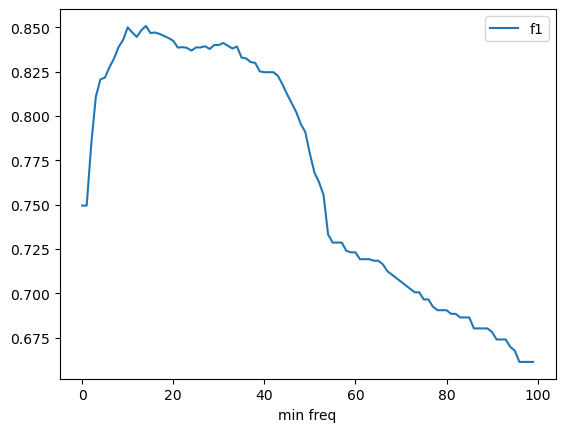

In [13]:
from collections import Counter

id_counter = Counter(id_counts_gold).most_common()
out = []
cols = ["min freq", "precision", "recall", "f1"]
best_f1 = -1
best_min_freq = 0


for min_freq in range(0, 100, 1):
    ids = [i for i, f in id_counter if f >= min_freq]
    preds = gold_label_table.docID.isin(ids)
    scores = precision_recall_fscore_support(labels, preds, 
                                             average="binary", zero_division=0)
    out.append([min_freq] + list(scores[:3]))
    
    f1 = scores[2]
    if best_f1 < f1:
        best_f1 = f1
        best_min_freq = min_freq


print("Best f1:", best_f1, "Best min freq:", best_min_freq)
out = pd.DataFrame(out, columns=cols)
out.plot(x="min freq", y="f1")